# Using Qurro with Arbitrary Compositional Data

Although Qurro was initially designed for use with microbiome sequencing data, it can totally be used on any sort of compositional data. The main challenge is just getting your data formatted properly.

We're going to demonstrate this by creating a Qurro visualization from "color composition data for 22 abstract paintings." These data were taken from Table 1 of [Aitchison and Greenacre (2002)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/1467-9876.00275).

## Requirements

This notebook relies on Python 3.5.3 or later, [biom-format](http://biom-format.org/), [DEICODE](https://github.com/biocore/DEICODE), and [Qurro](https://github.com/biocore/qurro) being installed. **TODO: add deps for biplot viz stuff**

## 0. Setting up

In this section, we replace the output directory with an empty directory. This just lets us run this notebook multiple times, without any tools complaining about overwriting files.

In [1]:
# Clear the output directory so we can write these files there
!rm -rf output/*
# Since git doesn't keep track of empty directories, create the output/ directory if it doesn't already exist
# (if it does already exist, -p ensures that an error won't be thrown)
!mkdir -p output

## 1. Getting the input data ready

At minimum, three files are needed to generate a Qurro visualization. This section goes into detail on each of these three files, and what they look like for the color composition data.

### 1.1. Feature Table
This is a table of abundance data detailing the frequencies of _features_ in _samples_. Qurro expects this table to be in the [BIOM format](http://biom-format.org/), but fortunately converting TSV files to BIOM [isn't too bad](http://biom-format.org/documentation/biom_conversion.html).

#### 1.1.1. Wait, hold on, what do you mean by "features" and "samples"?
In the color composition data, we consider each of the 22 paintings as a *sample*, and each color (e.g. `Red`) as a *feature*.

#### 1.1.2. Example file
We've provided a TSV file **`input/color-table.tsv`** containing the color composition data for the 22 paintings. Notice how the columns are samples, and the rows are features.

In [2]:
from qurro._metadata_utils import read_metadata_file_sane
table_file = read_metadata_file_sane("input/color-table.tsv")
table_file.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
SampleID,,,,,,,,,,,,,,,,,,,,,
Black,0.125,0.143,0.147,0.164,0.197,0.157,0.153,0.115,0.178,0.164,...,0.155,0.126,0.199,0.163,0.136,0.184,0.169,0.146,0.200,0.135
White,0.243,0.224,0.231,0.209,0.151,0.256,0.232,0.249,0.167,0.183,...,0.251,0.273,0.170,0.196,0.185,0.152,0.207,0.240,0.172,0.225
Blue,0.153,0.111,0.058,0.120,0.132,0.072,0.101,0.176,0.048,0.158,...,0.091,0.045,0.080,0.107,0.162,0.110,0.111,0.141,0.059,0.217
Red,0.031,0.051,0.129,0.047,0.033,0.116,0.062,0.025,0.143,0.027,...,0.085,0.156,0.076,0.054,0.020,0.039,0.057,0.038,0.120,0.019
Yellow,0.181,0.159,0.133,0.178,0.188,0.153,0.170,0.176,0.118,0.186,...,0.161,0.131,0.158,0.144,0.193,0.165,0.156,0.184,0.136,0.187


#### 1.1.3. Converting from TSV to BIOM
We need to convert this TSV file to a BIOM file that can be used with Qurro:

In [3]:
!biom convert \
    -i input/color-table.tsv \
    --to-json \
    -o output/color-table.biom

#### 1.1.4. Summarize the newly created BIOM file
The ` | head -4` thing below just means "only show the first four lines of the output summary."

In [4]:
!biom summarize-table -i output/color-table.biom | head -4

Num samples: 22
Num observations: 6
Total count: 21
Table density (fraction of non-zero values): 1.000


### 1.2. Sample Metadata

This is a file containing descriptive information about samples, where each sample has a row in the file and each sample metadata field has a column in the file. Qurro expects this to be a [TSV file](https://en.wikipedia.org/wiki/Tab-separated_values).

#### 1.2.1. What sort of "metadata" do we have for the color composition data?
We don't have much, honestly. Just from Table 1 in [Aitchison and Greenacre (2002)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/1467-9876.00275), all we really know about a given painting is its color composition.

For illustrative purposes (we need _some_ sort of sample metadata to run Qurro), we've added `proportion_blue`, `proportion_black`, etc. columns to the sample metadata, as well as a `data_source` column which is just `AitchisonGreenacre2002` for all samples. These columns are obviously a bit silly; if we were super interested in studying _why_ certain paintings seem different, you could imagine us taking the time to investigate and then adding in more useful metadata columns like `artist`, `date painted`, `canvas height`, etc.

#### 1.2.2. Example file
We've provided an example TSV file, **`input/color-sample-metadata.tsv`**, containing the sample metadata for the color composition data. This file is suitable as-is for use in Qurro as sample metadata.


In [5]:
metadata_file = read_metadata_file_sane("input/color-sample-metadata.tsv")
metadata_file.head()

,proportion_black,proportion_white,proportion_blue,proportion_red,proportion_yellow,proportion_other,data_source
SampleID,,,,,,,
1,0.125,0.243,0.153,0.031,0.181,0.266,AitchisonGreenacre2002
2,0.143,0.224,0.111,0.051,0.159,0.313,AitchisonGreenacre2002
3,0.147,0.231,0.058,0.129,0.133,0.303,AitchisonGreenacre2002
4,0.164,0.209,0.120,0.047,0.178,0.282,AitchisonGreenacre2002
5,0.197,0.151,0.132,0.033,0.188,0.299,AitchisonGreenacre2002


### 1.3. Feature Rankings (in this case, feature loadings in a biplot)

By "feature rankings," we usually mean either the feature loadings in a biplot or "differentials." Please see Qurro's paper ([preprint here](https://www.biorxiv.org/content/10.1101/2019.12.17.880047v1)) for more details on what these terms mean.

We're going to generate a biplot for the color composition abundance data using [DEICODE](https://github.com/biocore/DEICODE), and use the feature loadings in that biplot as the feature rankings.

#### 1.3.1. Run DEICODE

Long story short, DEICODE just generates a biplot from compositional data (after performing a few steps). For details, please see [Martino et al. 2019](https://msystems.asm.org/content/4/1/e00016-19).

In [6]:
!deicode auto-rpca \
    --min-feature-count 0 \
    --min-sample-count 0 \
    --in-biom output/color-table.biom \
    --output-dir output/deicode-results

/home/marcus/.local/lib/python3.6/site-packages/biom/table.py:4049: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  for r in self.matrix_data.tocsr()]
/home/marcus/.local/lib/python3.6/site-packages/biom/table.py:4052: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return constructor(mat, index=index, columns=columns)
/home/marcus/Software/miniconda2/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/sparse/frame.py:854: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead

In [7]:
!ls output/deicode-results

distance-matrix.tsv  ordination.txt


The sample and feature loadings of the biplot are contained in `ordination.txt`.

## 2. Visualize the biplot
When the feature rankings we're using are feature loadings in a biplot, it can be really useful to look at the biplot alongside the Qurro visualization.

Code below c/o [Cameron Martino](https://github.com/biocore/DEICODE/blob/master/ipynb/tutorials/assets/plotting_helper.py).

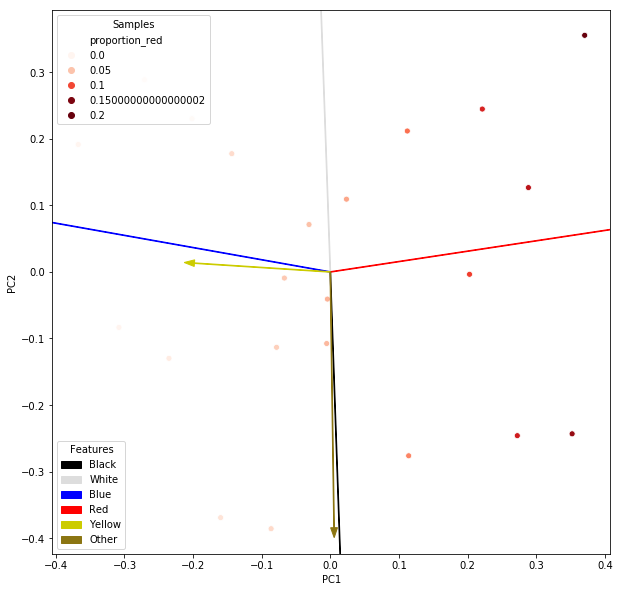

In [100]:
from skbio import OrdinationResults
# from plotting_helper import biplot
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

# Load the sample and feature loadings
ordination = OrdinationResults.read("output/deicode-results/ordination.txt")

sload = ordination.samples.copy()
fload = ordination.samples.copy()

# Rename the axes from 0, 1, 2, ... to PC1, PC2, PC3, ...
for df in (sload, fload):
    df.columns = ["PC{}".format(i + 1) for i in range(len(df.columns))]

# Start drawing figure using pyplot
fig, ax = pyplot.subplots(1, 1, figsize=(10, 10))

# Plot the samples (points)
sns.scatterplot(
    "PC1", "PC2", data=sload, ax=ax, hue=metadata_file["proportion_red"].astype(float), palette="Reds"
)

# Plot the features (arrows)
arrow_cmap = {
    "Black": "#000000", "White": "#dddddd", "Blue": "#0000ff", "Red": "#ff0000",
    "Yellow": "#cccc00", "Other": "#8b7512"
}

legend_arrows = {}
for i in range(len(ordination.features)):
    # add arrow
    ind_ = ordination.features.index[i]
    arrow_  = ax.arrow(0, 0, ordination.features.loc[ind_, 0],
                    ordination.features.loc[ind_, 1],
                    color=arrow_cmap[ind_],
                    width=0.001, head_width=0.01)
    legend_arrows[ind_] = arrow_

# Set up sample legend
sample_legend = ax.legend(loc='upper left', title="Samples")
ax.add_artist(sample_legend)

# ... And feature legend
ax.legend(list(legend_arrows.values()),
          list(legend_arrows.keys()), 
          loc='lower left',
          title="Features")

pyplot.show()

## 3. Run Qurro

In [101]:
!qurro \
    --table output/color-table.biom \
    --sample-metadata input/color-sample-metadata.tsv \
    --ranks output/deicode-results/ordination.txt \
    --output-dir output/qurro-viz/

/home/marcus/Dropbox/Work/KnightLab/qurro/qurro/_df_utils.py:126: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  table_sdf = pd.SparseDataFrame(table.matrix_data, default_fill_value=0.0)
/home/marcus/Software/miniconda2/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/home/marcus/Software/miniconda2/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
